# Particle Filter
## Key idea
- Particleを並行してシミュレートしその平均によって状態を推定する．
- データからParticleの重み(尤度に比例)を計算し
    - 重要なparticleは分裂，
    - 重要でないparticleは消滅させる．
## 状態空間モデル
## アルゴリズム
1. update
    - モデルに従って．各particleを時間発展．
2. weight
    - 各particleから観測データが得られる尤度を計算し重みとする．
3. resampling

## パラメータ
- $m$: particle数．
- $N_{shr}$: 実効particle数域値．

## 実装上の注意
- 尤度の計算を正規分布の密度関数で行うと値が小さくなりすぎて数値的に破綻する．-> 対数尤度を使う．

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# %load_ext Cython

# モジュールの読み込み
import sys
sys.path.append('./module')
from utils import make_lorenz96, rk4, error_series_kf, plot_error_KF, estimate_error_with_params
# from kalman_filters import LocalEnsembleTransformKalmanFilter as LETKF

In [2]:
# Lorenz96の設定
J = 40
F = 8
lorenz = make_lorenz96(F)

# 同化step
# 時間発展は0.01ごとに行う
dt = 0.05

# モデルの遷移関数(非線形)
# 0.01ずつ時間発展させる
# dtは同化step
def M(x, dt):
    return rk4(0, x, dt, lorenz) # 計算をさぼる
    # for i in range(int(dt/0.01)):
    #     x = rk4(0, x, 0.01, lorenz)
    # return x

# 単位行列
I = np.identity(J)

# 観測
H = I

# モデル誤差共分散, 最初は完全モデルを仮定
Q = np.zeros((J, J))

# 観測誤差共分散, 後で定数倍の変化をさせる.
R = I

# 観測値と真値
y = np.load('data/obs_atr.npy')
true = np.load('data/true_atr.npy')

In [10]:
# %%cython
import numpy as np
from numpy.linalg import inv
class ParticleFilter:
    def __init__(self, M, H, R, y, X_0, N_thr, dt=0.05):
        self.M = M
        self.H = H
        self.R = R
        self.y = y
        self.N_thr = N_thr
        self.dt = dt
        self.m = X_0.shape[0]
        self.idx = np.arange(self.m)
        
        # iterate用particles
        self.X = X_0 # (m, N)

        # 記録用
        self.x = []
        self.trP = []
        self.resample_log = []

    def forward_estimate(self):
        for y_obs in self.y:
            self._forecast()
            self._resampling(y_obs)
            self.x.append(self.X.mean(axis=0))

    def resampling_rate(self):
        return np.mean(self.resample_log)

    def _forecast(self):
        self._compute_trP()
        # 各particleで予測
        for i, s in enumerate(self.X):
            self.X[i] = self.M(s, self.dt)# + np.random.normal(loc=0, scale=1e-5/self.trP[-1])
         
    def _resampling(self, y_obs):
        # TODO: 成分ごとにresampling
        log_w = np.array([self._log_likelihood(x, y_obs) for x in self.X])
        log_w = log_w - log_w.max()
        W_tmp = np.exp(-log_w)
        W_tmp = W_tmp/W_tmp.sum() # 規格化
        print(W_tmp.max())

        if True or self._caluculate_eff(W_tmp) < self.N_thr: # NOTE: 100%resampleする
            # reindex = self._resample(W_tmp)
            reindex = self._resample_by_choice(W_tmp)
            self.X = self.X[reindex]
            self.resample_log.append(1)
            
        else:
            self.resample_log.append(0)
    
    def _resample_by_choice(self, W):
        reindex = np.random.choice(self.idx, size=self.m, p=W, replace=True) # Weightに従ってサンプル．
        return reindex

    def _log_likelihood(self, x, y_obs):
        H = self.H; R = self.R; m = self.m
        return (y_obs - H@x)@inv(R)@(y_obs - H@x)/(m-1)

    def _caluculate_eff(self, W):
        return 1/(W@W)
    
    def _compute_trP(self):
        dX = self.X - self.X.mean(axis=0)
        self.trP.append(np.sqrt(np.trace(dX.T@dX)/(m-1)))
    
    # def _resample(self, W): # この実装は精度が悪い．
    #     reindex = []
    #     for k in range(self.m):
    #         u = np.random.rand()
    #         reindex.append(self._F_inv(u, W))
    #     return reindex
        # print('X:{}'.format(self.X))
        # print(reindex)
        # print('X_re: {}'.format(self.X[reindex]))
    
    # 重み累積分布関数の逆関数
    # def _F_inv(self, u, W):
    #     """
    #     W: np ndarray (m, )
    #     u: float
    #     """
    #     F = W.cumsum()
        
    #     if u < F[0]:
    #         return 0
    #     else:
    #         return F[F < u].argmax() + 1

1.0
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333333
0.03333333333333

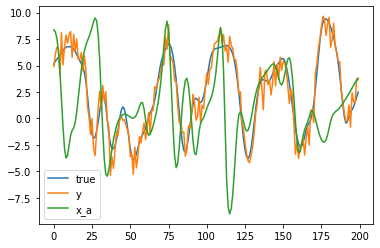

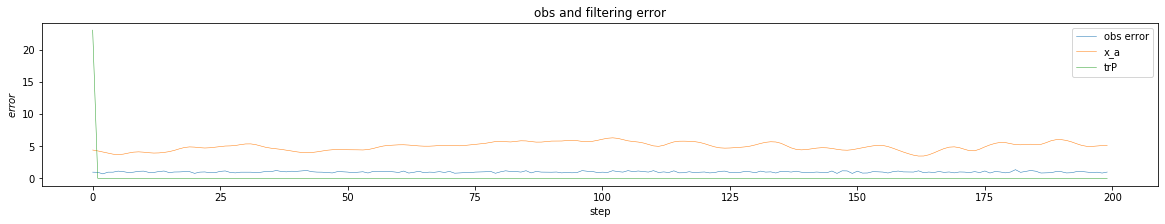

1.0
CPU times: user 12.8 s, sys: 216 ms, total: 13 s
Wall time: 1.93 s


In [11]:
%%time
# Particle Filterの初期値
m = 30
np.random.seed(0)
X_0 = true[np.random.choice(range(len(true)), m)]

start = 0
end = 200
pf = ParticleFilter(M, H, R, y[start:end], X_0, N_thr=m*1.1)
pf.forward_estimate()

idx = 9
fig1, ax1 = plt.subplots()
ax1.plot(true[start:end, idx], label='true')
ax1.plot(y[start:end, idx], label='y')
ax1.plot(np.array(pf.x)[:, idx], label='x_a')
plt.legend()
plot_error_KF(true[start:end], y[start:end], [pf.x], trPs=[pf.trP], legends=['x_a'])
print(pf.resampling_rate())
# _, _, rmse = estimate_error_with_params(true, [letkf.x], [m], 'm')

観察
- 途中でfilter divergenceが起きている．